In [ ]:
%pip --quiet install git+https://github.com/mfinzi/equivariant-MLP.git

In [ ]:
import emlp
from emlp.datasets import *
from emlp.groups import *

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from jax import vmap


import matplotlib.pyplot as plt

def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))

In [ ]:
def train_emlp(G, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384, batch_size=500, lr=3e-3, num_epochs=5):
  
  print(f"Input type: {train.rep_in(G)}, output type: {train.rep_out(G)}")
  model = emlp.nn.EMLP(train.rep_in, train.rep_out, group=G, num_layers=num_layers, ch=channels)
  
  opt = objax.optimizer.Adam(model.vars())

  @objax.Jit
  @objax.Function.with_vars(model.vars())
  def loss(x, y):
      yhat = model(x)
      return ((yhat-y)**2).mean()

  grad_and_val = objax.GradValues(loss, model.vars())

  @objax.Jit
  @objax.Function.with_vars(model.vars()+opt.vars())
  def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v

  trainloader = DataLoader(train, batch_size=batch_size,shuffle=True)
  testloader = DataLoader(test, batch_size=batch_size,shuffle=True)
  
  train_losses = []
  test_losses = []
  for epoch in tqdm(range(num_epochs)):
    train_losses.append(np.mean([train_op(jnp.array(x), jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch % 10:
      test_losses.append(np.mean([loss(jnp.array(x), jnp.array(y)) for (x,y) in testloader]))
  
  def equivariance_err(G, train, mb):
    rin,rout = train.rep_in(G),train.rep_out(G)
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

  #print(f"Average test equivariance error {np.mean([equivariance_err(G, train, mb) for mb in testloader]):.2e}")
  return train_losses, test_losses

In [ ]:
def compare_groups(grps, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384, batch_size=5, lr=3e-3, num_epochs=5):
  for name, G in grps.items():
    train_losses, test_losses = train_emlp(G, train, test, num_layers, channels, batch_size, lr, num_epochs)
    plt.plot(np.arange(num_epochs), train_losses, label=name + ' train loss')
    plt.plot(np.arange(0, num_epochs, 10),test_losses, label=name+' test loss')
  plt.legend()
  plt.yscale('log')
  plt.show()

Input type: 5V⁰+5V, output type: V²



Average test equivariance error 1.86e-07
Input type: 5V⁰+5V, output type: V²



Average test equivariance error 1.49e-07


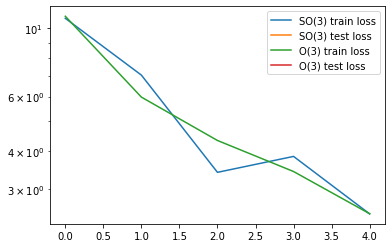

In [ ]:
grps = {'SO(3)': SO(3), 'O(3)': O(3)}
compare_groups(grps)